In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(gammapy)

loaded gammapy version: 0.1.dev19174+g56b5bdf 
<module 'gammapy' from '/home/wecapstor1/caph/mppi045h/gammapy/gammapy/__init__.py'>


In [2]:
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)



In [3]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
    CompoundNormSpectralModel,
    IRFModels, 
    ERecoIRFModel,
    EffAreaIRFModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('/home/katrin/Documents/nuisance_summary/')
sys.path.append('../../')
from Dataset_Creation import sys_dataset
import Dataset_load 

In [4]:
config = Dataset_load.load_config()
colors = config['colors']['one']

## Read dataset

In [5]:
scaled_amplitude = Parameter('amplitude', 
                             value = 1e-12)
dataset_input  = Dataset_load.create_asimov(model = 'pl', source = "PKSflare", 
                                            parameters = Parameters([scaled_amplitude,
                                                                    ]))
print(dataset_input)
source_model = dataset_input.models[0].copy()


emask = dataset_input.mask.data.sum(axis=2).sum(axis=1)>0
energy = dataset_input.geoms['geom'].axes[0].center[emask]

loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-pl.fits.gz
MapDataset
----------

  Name                            : 1nZ1RO5N 

  Total counts                    : 414547 
  Total background counts         : 413238.21
  Total excess counts             : 1309.11

  Predicted counts                : 414547.31
  Predicted background counts     : 413238.21
  Predicted excess counts         : 1309.11

  Exposure min                    : 1.57e-25 m2 s
  Exposure max                    : 1.27e+11 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 942469 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 850189.06

  Number of models                : 2 
  Number of parameters            : 8
  Number of free parameters       : 6

  Component 0: SkyModel
  
    Name                      : aEaZD8Bs
    Datasets names            : None
    Spectral model type       : PowerLawSpe

(<WCSAxes: >, <Axes: xlabel='Energy [TeV]', ylabel='Residuals (data - model)'>)

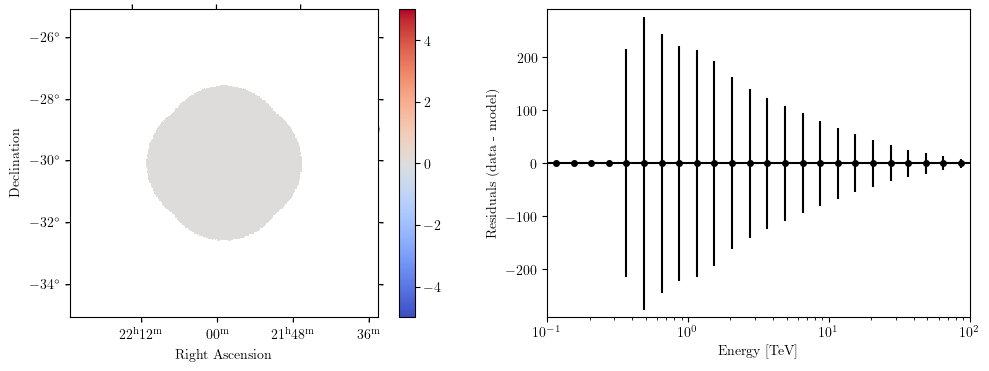

In [6]:
dataset_input.plot_residuals()

## Asimov Cases

In [7]:
dataset_asimov = dataset_input.copy()
dataset_asimov.models =  Models([source_model.copy(), 
                                 FoVBackgroundModel(dataset_name=dataset_asimov.name)])
dataset_asimov.models.parameters['tilt'].frozen = False
print(dataset_asimov.models)

DatasetModels

Component 0: SkyModel

  Name                      : pJdgopDf
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : HKHVU0o2-bkg
  Datasets names            : ['HKHVU0o2']
  Spectral model type       : PowerLawNormSpectralModel
  Spatial  model type       : 
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                          :      0.000   +/-    0.00             
    refer

In [8]:
def set_up_dataset_asimov_N(dataset_asimov):
    dataset_asimov_N = dataset_asimov.copy()

    energy = dataset_asimov_N.geoms['geom'].axes[0].center
    l = len(energy)
    norms = Parameters([Parameter ("norm"+str(i), value = 0, is_penalised = True, 
                                   frozen = False) for i in range(l)])
    for n in norms[~emask]:
        print(n.name)
        n.frozen = True
    piece = PiecewiseNormSpectralModel(energy = energy,
                              norms = norms,
                                      interp="lin")

    import operator
    bkg_spectral = CompoundNormSpectralModel(model1 = piece, 
                                            model2 = PowerLawNormSpectralModel(),
                                            operator= operator.add)

    bkg_sys = FoVBackgroundModel(spectral_model = bkg_spectral,
                                dataset_name= dataset_asimov_N.name)

    irf = IRFModels(datasets_names=dataset_asimov_N.name, 
                   e_reco_model=ERecoIRFModel(),
                   eff_area_model=EffAreaIRFModel())

    bkg_sys.parameters['tilt'].frozen = False
    dataset_asimov_N.models = Models([source_model.copy(), bkg_sys,irf])
    dataset_asimov_N.models.parameters['tilt_nuisance'].frozen = False
    dataset_asimov_N.models.parameters['resolution'].frozen = True
    
    return dataset_asimov_N

In [9]:
dataset_asimov_N = set_up_dataset_asimov_N(dataset_asimov)

norm0
norm1
norm2
norm3


## Cov matrix

In [10]:
true_energy = dataset_input.exposure.geom.axes[0].center.value
zero = 1e-12
shift_as = 0.1
tilt_as = 0.02
bias_as, resolution_as = 0.1,zero

values = [bias_as, resolution_as,
             shift_as, tilt_as]

In [11]:
from scipy.stats import norm
def cov_matrix(values):
    sys_percentage = np.array([10] * 24)
    l = len(sys_percentage)

    print("bkg para:",l)
    all_l = len(dataset_asimov_N.models.parameters.penalised_parameters)
    print("all para:",all_l)


    scale = 2
    cov = np.identity(all_l)

    # note: values set arbitrarily 
    for i in range(l):
        if sys_percentage[i] > 0:
            gau = norm.pdf(range(l) , loc = i , scale = scale )
            cov[i,:l] = gau / np.max(gau) * sys_percentage[i] / 100 
            cov[i,:l] += [1e-12] * (l)

    zero = 1e-24
    
    for parname, parvalue in zip(dataset_asimov_N.models[-1].parameters.names, 
                                values):
        idx = np.where(np.array(dataset_asimov_N.models.parameters.penalised_parameters.names) == parname)[0][0]
        cov[idx, idx]  = parvalue**2
        print(parname, idx, parvalue**2)
    return cov
cov = cov_matrix(values)

bkg para: 24
all para: 28
bias 24 0.010000000000000002
resolution 25 1e-24
norm_nuisance 26 0.010000000000000002
tilt_nuisance 27 0.0004


0.10000000000100001


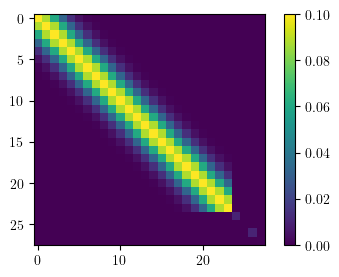

In [12]:

    
from numpy.linalg import inv
ainv = inv(cov)
dataset_asimov_N.penalising_invcovmatrix = ainv

fig, (ax1) = plt.subplots(figsize=(5, 3), ncols=1)
pos =plt.imshow(cov, vmin = 0., vmax = 0.1)
fig.colorbar(pos, ax=ax1)
print(cov.max())

fig.savefig("plots/2_cov_matrix.pdf", bbox_inches="tight")
fig.savefig("plots/2_cov_matrix.png", bbox_inches="tight")

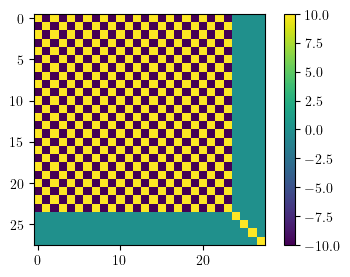

In [13]:
fig, (ax1) = plt.subplots(figsize=(5, 3), ncols=1)
pos =plt.imshow(ainv, vmin = -10, vmax = 10)
fig.colorbar(pos, ax=ax1)

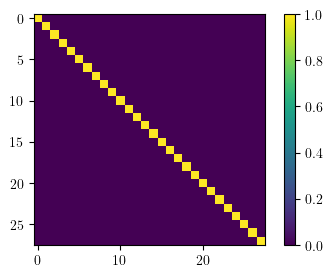

In [14]:
from numpy.linalg import inv

fig, (ax1) = plt.subplots(figsize=(5, 3), ncols=1)
pos =plt.imshow(np.matmul(cov,ainv), vmin = 0, vmax = 1)
fig.colorbar(pos, ax=ax1)

corr
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8.502e+05                  │              Nfcn = 100              │
│ EDM = 0.000359 (Goal: 0.0002)    │           time = 13.9 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬────────

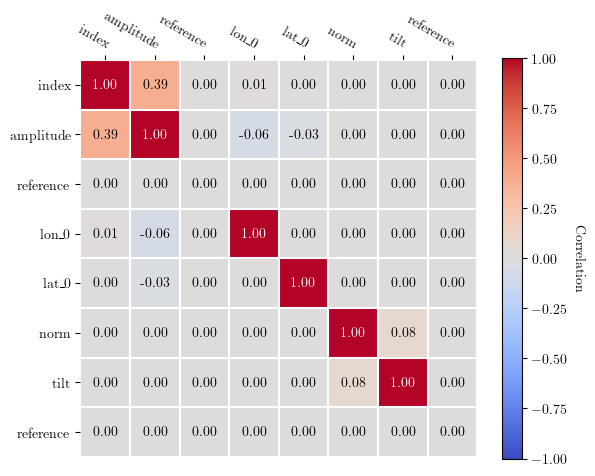

In [15]:
%%time
fitting = 1

if fitting:

    print("corr")
    fit_cor = Fit(store_trace=True)
    #minuit_opts = {"tol": 0.001, "strategy": 2}
    #fit_cor.optimize_opts = minuit_opts
    result_cor = fit_cor.run(dataset_asimov)
    #dataset_cor.models.covariance = fit_cor.covariance(dataset_asimov).matrix
    dataset_asimov.models.covariance.plot_correlation()
    print(fit_cor.minuit)
    
    path = f'data/2_model.yml'
    dataset_asimov.models.write(path,overwrite=True)
    
else:
    print("read")
    path = f'data/2_model.yml'
    dataset_asimov = Dataset_load.load_dataset(dataset_asimov, path)        
         
    



In [16]:
print(dataset_asimov.models)

DatasetModels

Component 0: SkyModel

  Name                      : pJdgopDf
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.05             
    amplitude                     :   1.00e-12   +/- 5.1e-14 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : HKHVU0o2-bkg
  Datasets names            : ['HKHVU0o2']
  Spectral model type       : PowerLawNormSpectralModel
  Spatial  model type       : 
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                          :      0.000   +/-    0.00             
    refer

corr
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8.502e+05                  │              Nfcn = 891              │
│ EDM = 0.000559 (Goal: 0.0002)    │           time = 464.3 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────────┬───────────┬───────────┬────────────┬────────────┬────

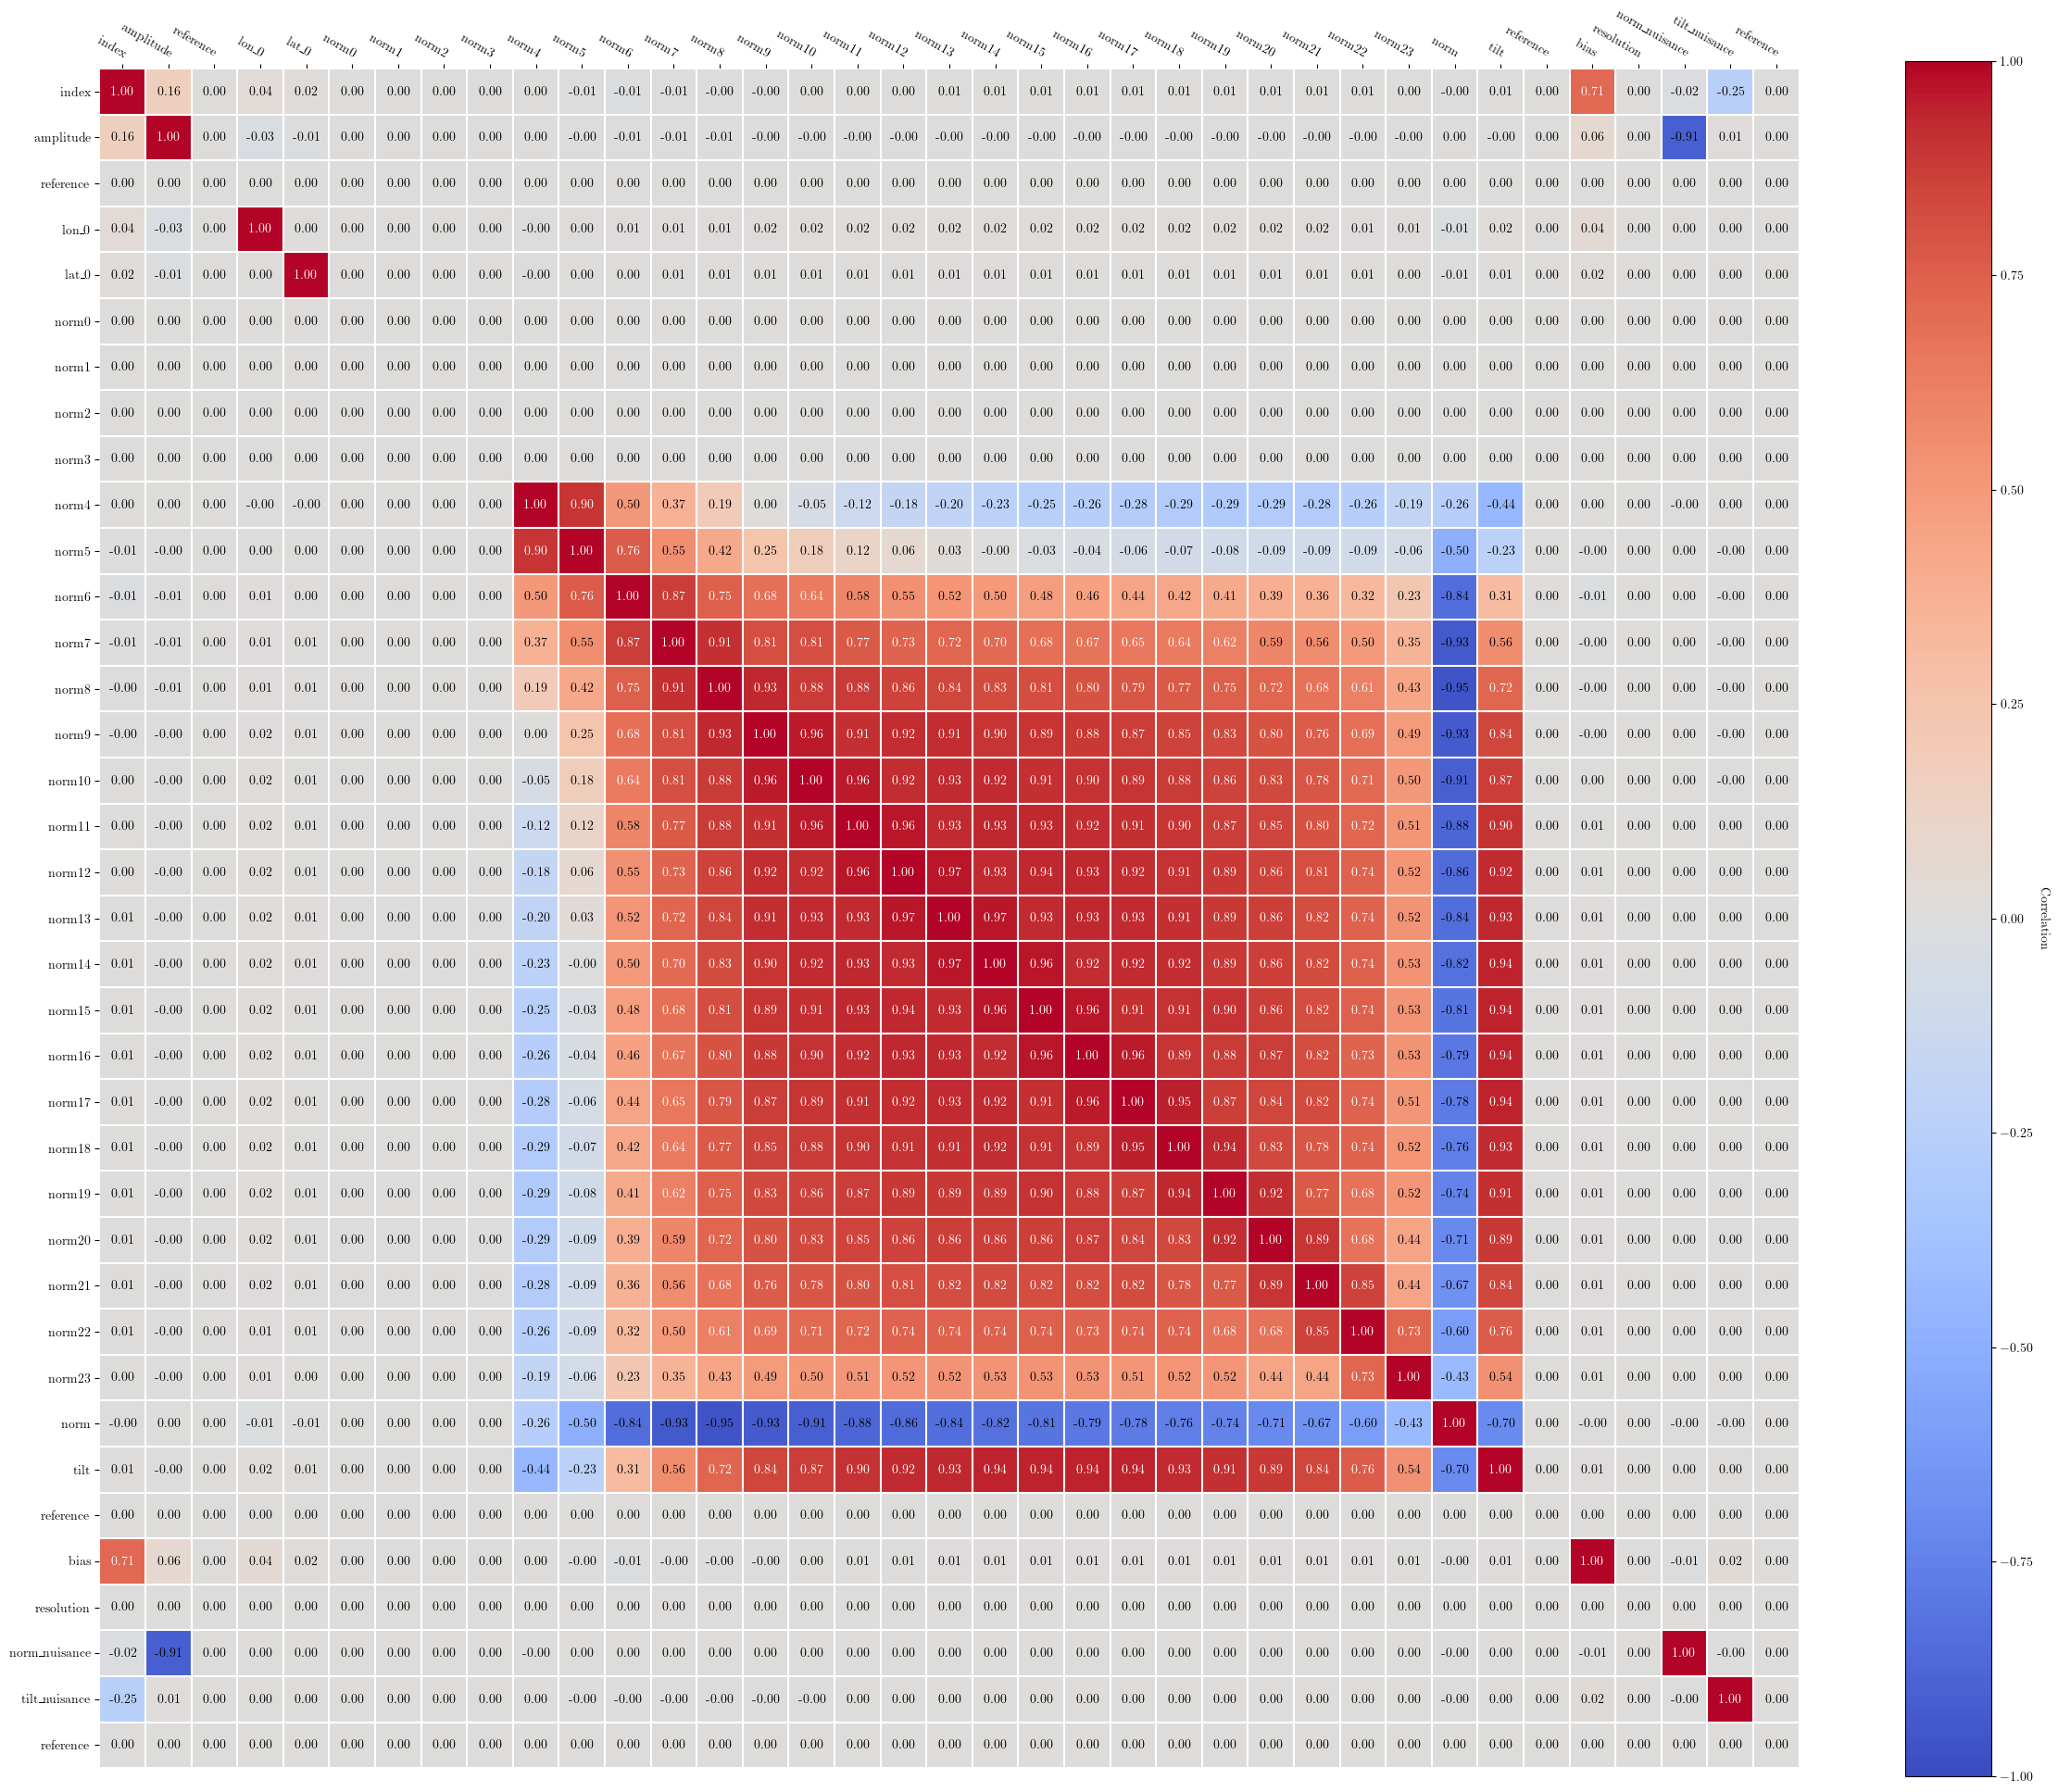

In [17]:
%%time
fitting = 1
#13min 25s

if fitting:

    print("corr")
    fit_cor = Fit(store_trace=True)
    #minuit_opts = {"tol": 0.001, "strategy": 2}
    #fit_cor.optimize_opts = minuit_opts
    result_cor = fit_cor.run(dataset_asimov_N)
    dataset_asimov_N.models.covariance = fit_cor.covariance(dataset_asimov_N).matrix
    dataset_asimov_N.models.covariance.plot_correlation()
    print(fit_cor.minuit)
    
    path = f'data/2_model_nui.yml'
    dataset_asimov_N.models.write(path,overwrite=True, )
    
else:
    print("read")
    path = f'data/2_model_nui.yml'
    dataset_asimov_N = Dataset_load.load_dataset_N(dataset_asimov_N, path, bkg_sys = True)        
         
    



<Axes: >

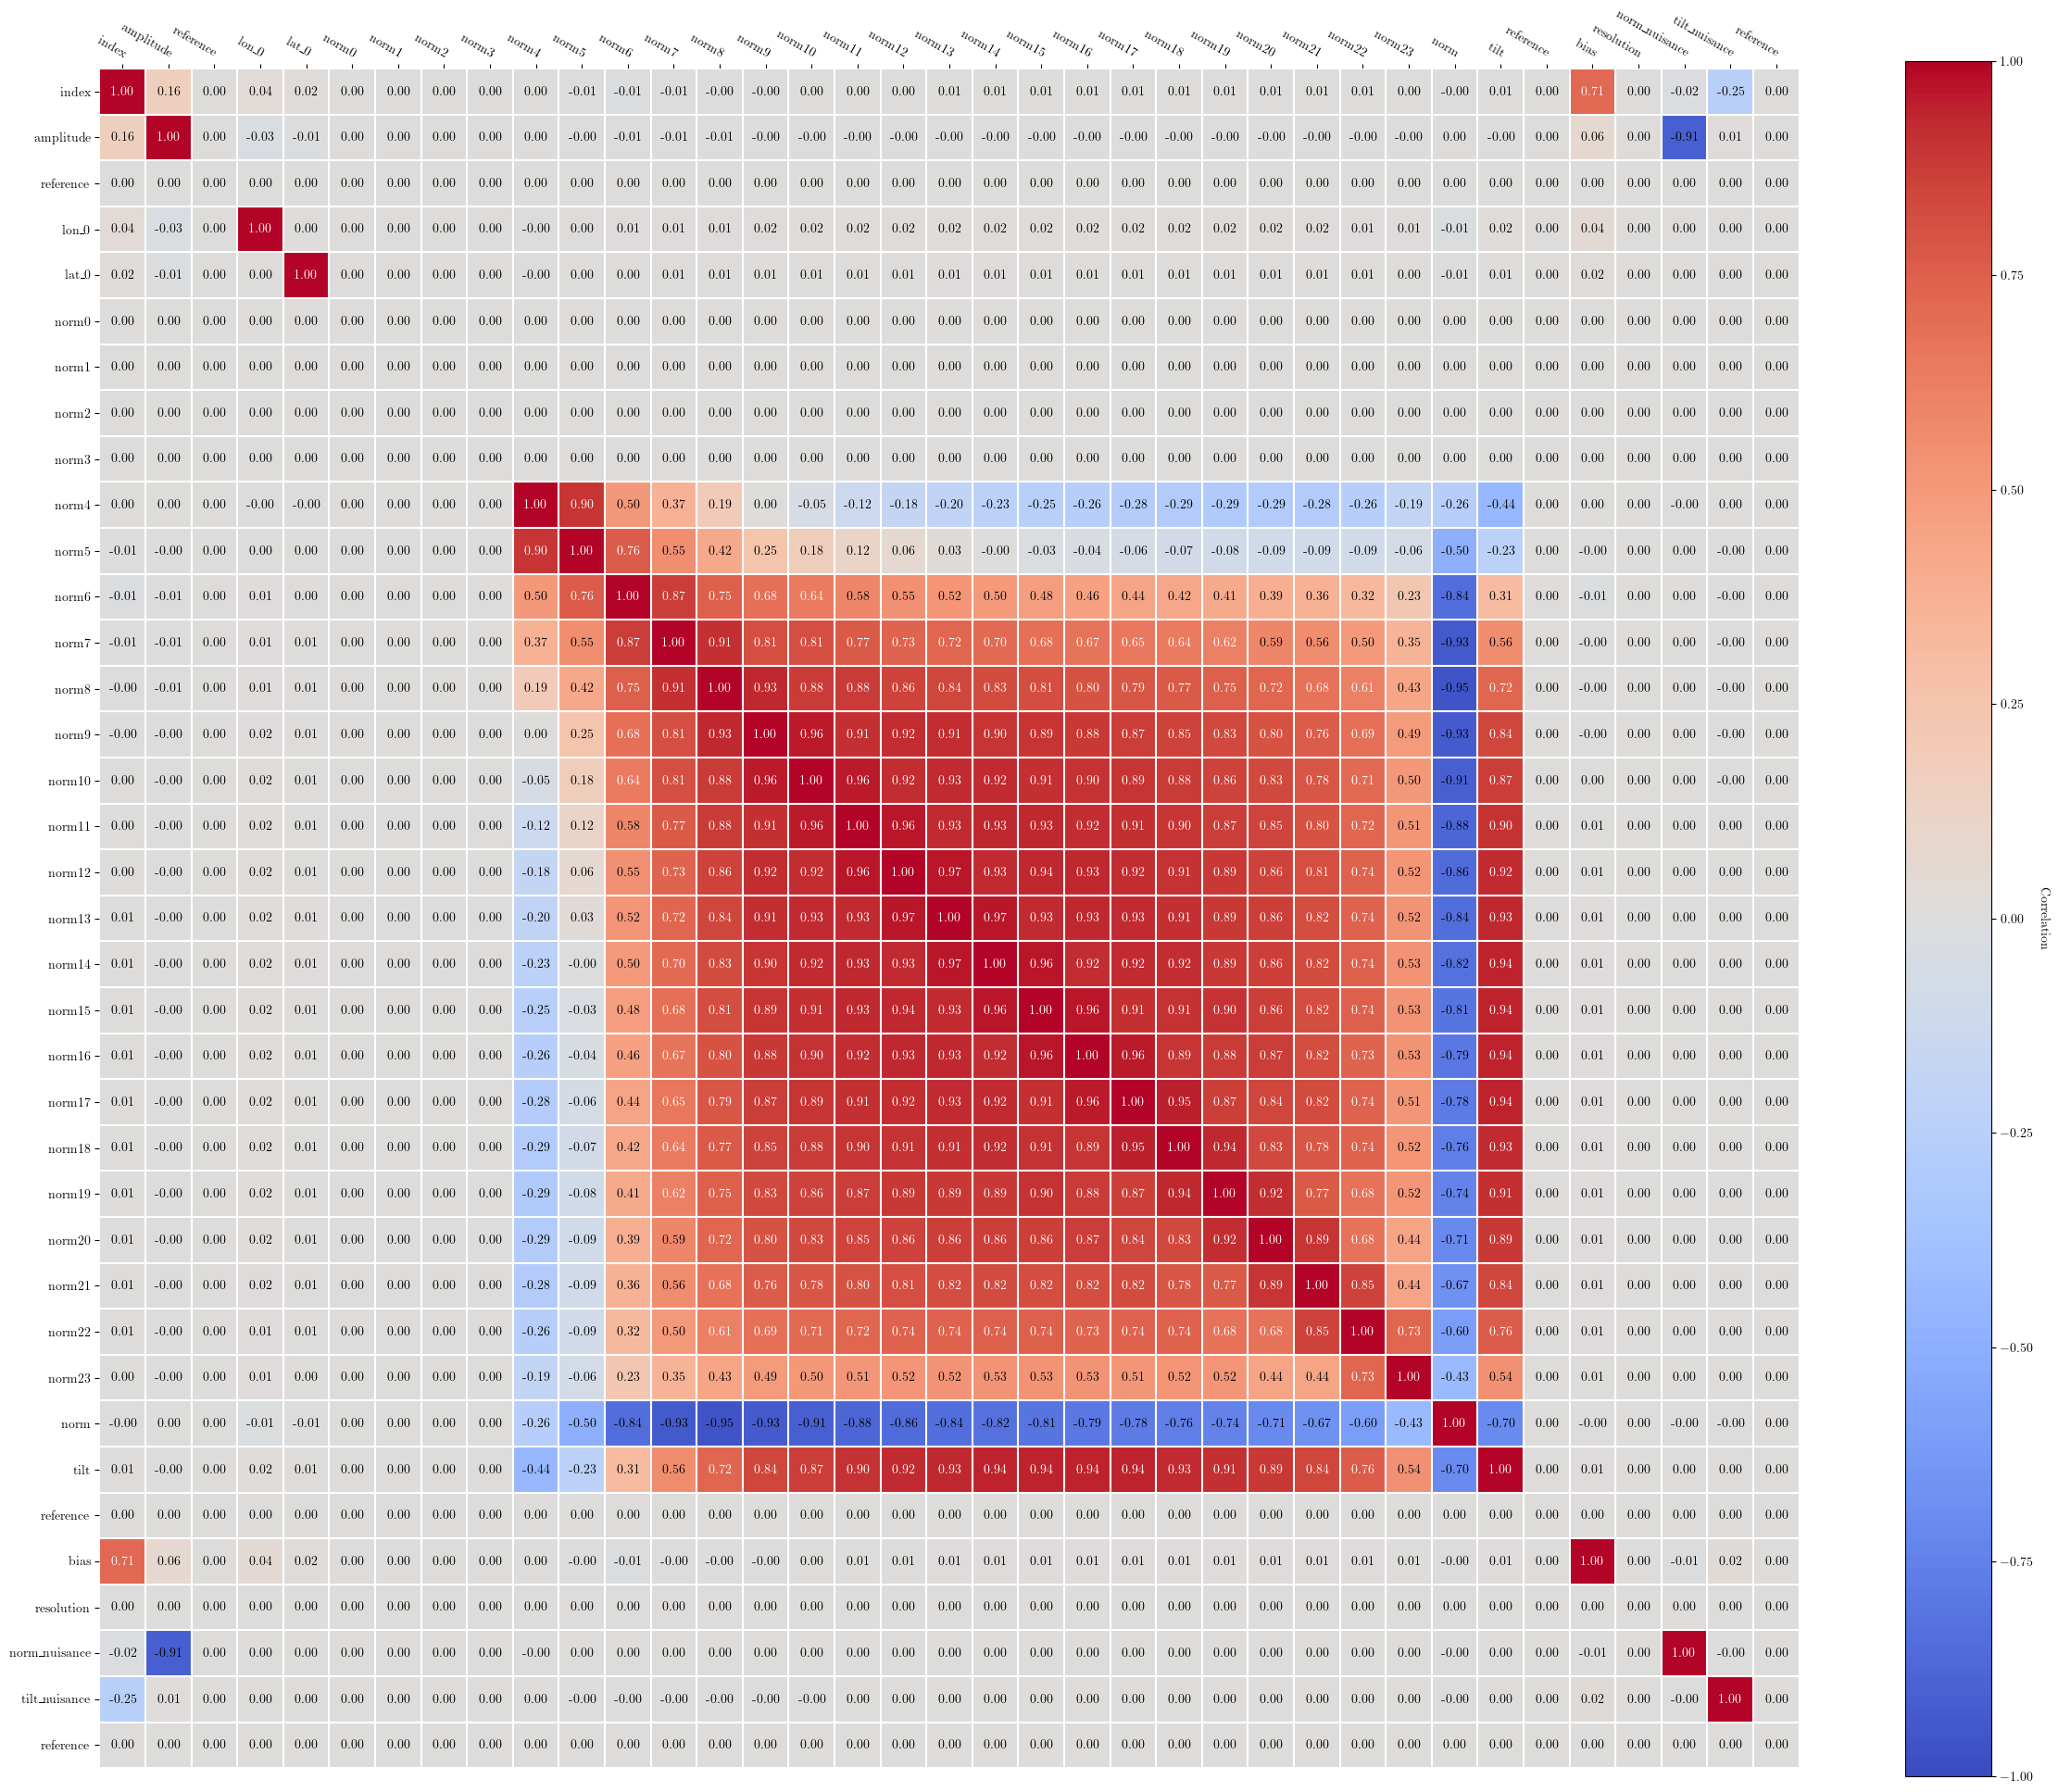

In [18]:
dataset_asimov_N.models.covariance.plot_correlation()

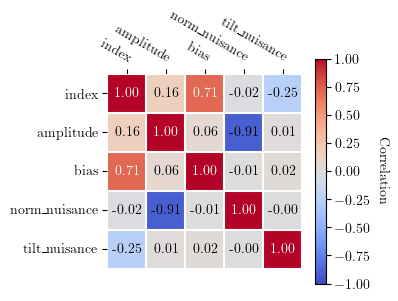

In [19]:
par_names = ['index', 'amplitude',  'bias',  'norm_nuisance' , 
            'tilt_nuisance']

#dataset_asimov_N.models.read_covariance("data", f"2_model_nui_covariance.dat", format="ascii.fixed_width")
parameters = Parameters([_ for _ in dataset_asimov_N.models.parameters if _.name in par_names])
cov_par = dataset_asimov_N.models.covariance.get_subcovariance(parameters)

ax = cov_par.plot_correlation(names = parameters.names)
plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/2_covmatrix_combination.png")

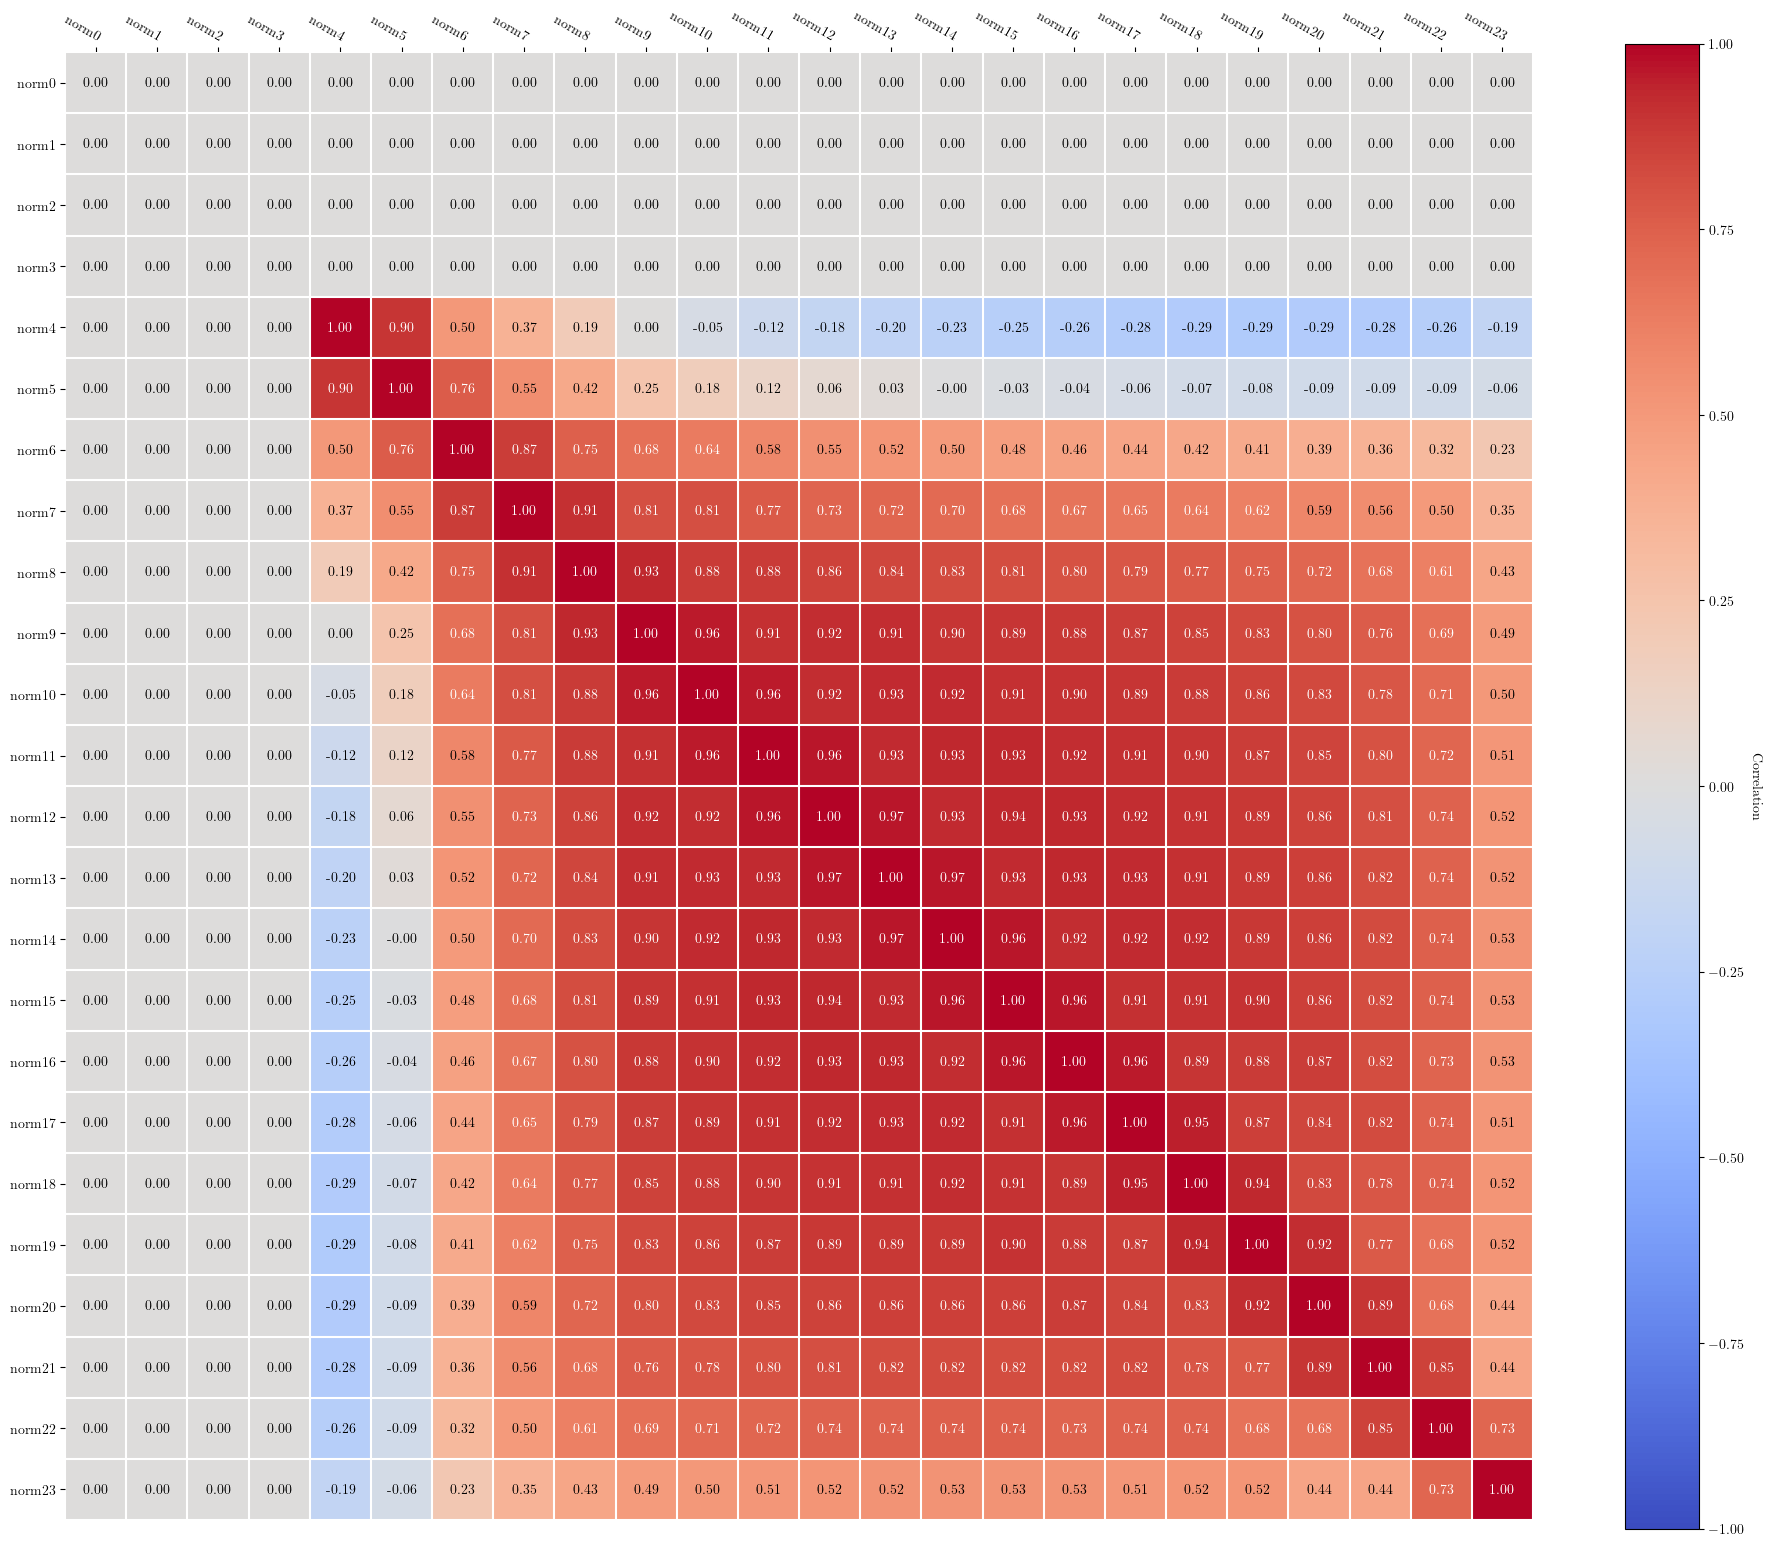

In [20]:
par_names = ['norm' + str(i) for i in range(24)]

parameters = Parameters([_ for _ in dataset_asimov_N.models.parameters if _.name in par_names])
cov_par = dataset_asimov_N.models.covariance.get_subcovariance(parameters)
names =  ['index', 'amplitude', 'lambda',
        'bkg norm', 'bkg tilt',
          'bias', 'resolution',
          'eff. area norm' , 
            'eff. area tilt']

ax = cov_par.plot_correlation(names = parameters.names)
plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/2_covmatrix_combination_bkg.png")

In [21]:
print(dataset_asimov_N.models)

DatasetModels

Component 0: SkyModel

  Name                      : 91CC9yfm
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.07             
    amplitude                     :   1.00e-12   +/- 1.2e-13 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : afEs0-lr-bkg
  Datasets names            : ['afEs0-lr']
  Spectral model type       : CompoundNormSpectralModel
  Spatial  model type       : 
  Parameters:
    norm0                 (frozen):      0.000                   
    norm1                 (frozen):      0.000                   
    norm2                

In [22]:
def plot_par(par1, par2, label,ax = None, fmt ='x', markersize = 6):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.errorbar(x = par1.value, y = par2.value, xerr = par1.error, yerr = par2.error, fmt= fmt,
                markersize = markersize,
                label = label)
    ax.set_xlabel(f"{par1.name} [{par1.unit}] " )
    ax.set_ylabel(f"{par2.name} [{par2.unit}] " )
    ax.legend()
    
    return ax

def plot_source_par(model_name, pars):
    if len(pars)>2:
        fig, ax = plt.subplots(2,2, figsize = (6,6))
        ax = ax.flatten()
    else:
        fig, ax = plt.subplots(1,2, figsize = (6,3))
   
    for i, p in enumerate(pars):
    
        for j, m in enumerate (models_list):
            try:
                plot_par(m.parameters[p[0]],
                 m.parameters[p[1]],
                    label= labels[j],
                    ax = ax[i],
                        fmt = fmts[j],
                        markersize = markersize[j])
            except:
                pass

    plt.tight_layout()

labels = ['simulated', 'recovered with nuisance', 'recovered']
fmts = ['o','x', '*']
markersize = [6,10, 11]

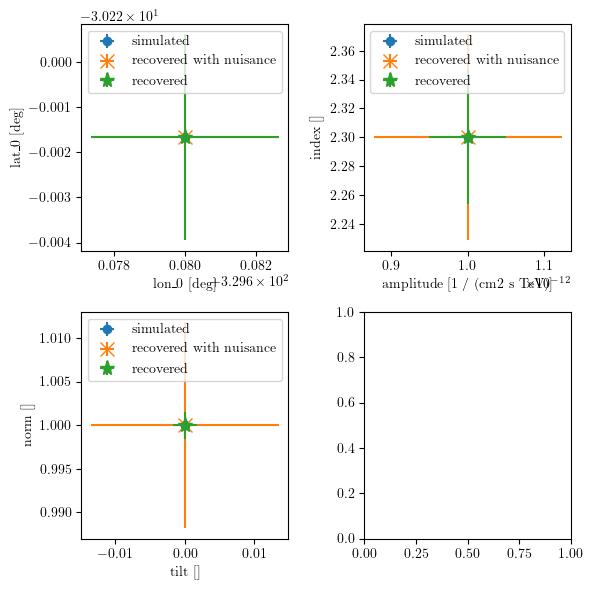

In [23]:
models_list = [dataset_input.models, dataset_asimov_N.models,dataset_asimov.models,  ]

pars =  pars = [('lon_0', 'lat_0'),('amplitude', 'index'), ('tilt', 'norm'),
               ]
plot_source_par(0, pars)


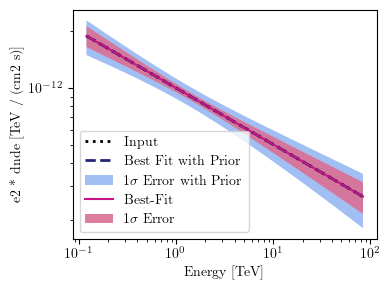

In [24]:
energy_bounds = (true_energy[0], true_energy[-1] ) * u.TeV

fig,axs = plt.subplots(1,1,figsize = (4,3))
energy_power=2
dataset_input.models[0].spectral_model.plot(energy_bounds, energy_power = energy_power, ax =axs, 
                                label = "Input", color = 'black', linewidth = energy_power, linestyle="dotted")
dataset_asimov_N.models[0].spectral_model.plot(energy_bounds,  energy_power = energy_power, ax = axs,color = colors[1],
                                                         label="Best Fit with Prior",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)
dataset_asimov_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = energy_power, ax = axs,
                                                       facecolor=colors[3],
                                                         label="$1\sigma$ Error with Prior",
                                                        alpha = 0.6)

dataset_asimov.models[0].spectral_model.plot(energy_bounds,  energy_power = energy_power, ax = axs,
                                label = "Best-Fit", color = colors[0])

dataset_asimov.models[0].spectral_model.plot_error(energy_bounds,  energy_power = energy_power, ax = axs,
                                                       facecolor=colors[2],
                                                          alpha = 0.9,
                                                          label= "$1\sigma$ Error"
                                                         )

axs.legend() 
plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/2_spectrum_comparison.png", dpi = 300)

In [25]:
par_name = "amplitude"
print(par_name)
par_input  = dataset_input.models.parameters[par_name]

par  = dataset_asimov_N.models.parameters[par_name]
print(f"Nusiacnce {par_input.value:.5}: {par.value:.5} \pm {par.error:.4}")
par  = dataset_asimov.models.parameters[par_name]
print(f"Standard  {par_input.value:.5}: {par.value:.5} \pm {par.error:.4}")



amplitude
Nusiacnce 1e-12: 1e-12 \pm 1.227e-13
Standard  1e-12: 1e-12 \pm 5.065e-14


In [26]:
par_name = "index"
print(par_name)
par_input  = dataset_input.models.parameters[par_name]

par  = dataset_asimov_N.models.parameters[par_name]
print(f"Nusiacnce {par_input.value:.5}: {par.value:.4} \pm {par.error:.4}")
par  = dataset_asimov.models.parameters[par_name]
print(f"Standard  {par_input.value:.5}: {par.value:.4} \pm {par.error:.4}")



index
Nusiacnce 2.3: 2.3 \pm 0.0715
Standard  2.3: 2.3 \pm 0.04634


In [27]:
par_name = "norm"
print(par_name)
par_input  = dataset_input.models.parameters[par_name]

par  = dataset_asimov_N.models.parameters[par_name]
print(f"Nusiacnce {par_input.value:.5}: {par.value:.4} \pm {par.error:.4}")
par  = dataset_asimov.models.parameters[par_name]
print(f"Standard  {par_input.value:.5}: {par.value:.4} \pm {par.error:.4}")



norm
Nusiacnce 1.0: 1.0 \pm 0.01182
Standard  1.0: 1.0 \pm 0.001565
